In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
#import gymnasium as gym
import numpy as np
from envs.two_player_dubins_car import TwoPlayerDubinsCarEnv


import jax
import jax.numpy as jnp
import haiku as hk
import optax

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm


In [ ]:
# 1. Define the quadratic function without haiku
def quadratic_fn(x):
    return x ** 2 - 2 * x + 1

# 2. Compute its gradient using jax
grad_fn = jax.jit(jax.grad(quadratic_fn))

# 3. Set up a gradient descent optimizer using optax
lr = 0.1
optimizer = optax.sgd(lr)

# 4. Create a loop to perform gradient descent
num_steps = 50
params = {'x': jnp.array(10.0)}  # starting point
opt_state = optimizer.init(params)
history = [params['x']]

for _ in range(num_steps):
    grads = {'x': grad_fn(params['x'])}  # Compute gradient for the current value of x
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    history.append(params['x'])




No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


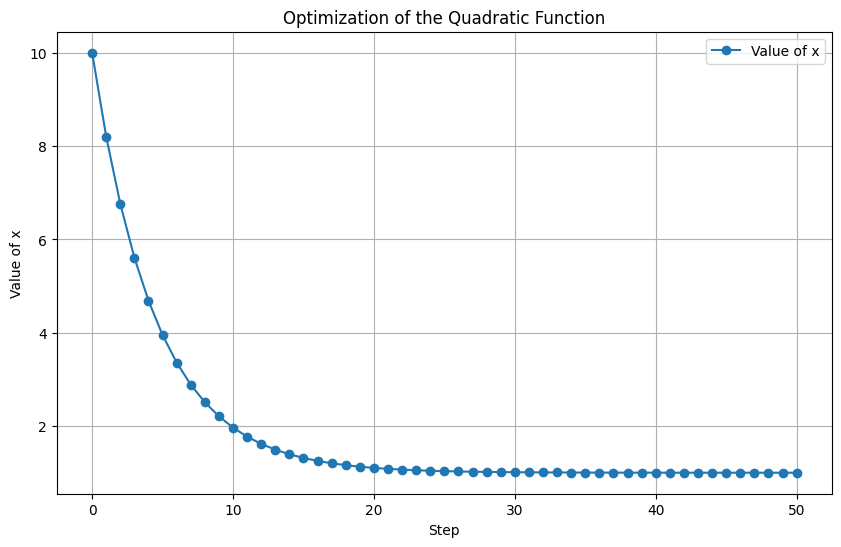

In [ ]:
import matplotlib.pyplot as plt

# Plotting the values
plt.figure(figsize=(10, 6))
plt.plot(history, '-o', label='Value of x')
plt.xlabel('Step')
plt.ylabel('Value of x')
plt.title('Optimization of the Quadratic Function')
plt.legend()
plt.grid(True)
plt.show()


In [32]:
# Define the Lagrangian
def lagrangian(x, lam):
    f = x ** 2 - 2 * x + 1
    g = x - 2
    return f + lam * jnp.maximum(0, g)

# Compute its gradient using jax with respect to x
grad_lagrangian = jax.jit(jax.grad(lagrangian, argnums=0))

# Initial lambda value and increase factor
lam = 0.1
lam_increase_factor = 1.01

# Updated loop to perform gradient descent with the Lagrangian
params = {'x': jnp.array(5.0)}  # starting point
opt_state = optimizer.init(params)
lagrangian_history = [lagrangian(params['x'], lam)]
x_history = [params['x']]

for _ in range(num_steps):
    grads = {'x': grad_lagrangian(params['x'], lam)}
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    
    # Increase lambda to enforce the constraint more strongly
    lam *= lam_increase_factor
    
    x_history.append(params['x'])
    lagrangian_history.append(lagrangian(params['x'], lam))

x_history[:10], lagrangian_history[:10]  # Display the first 10 steps


([Array(5., dtype=float32, weak_type=True),
  Array(4.19, dtype=float32),
  Array(3.5419002, dtype=float32),
  Array(3.0233192, dtype=float32),
  Array(2.6083524, dtype=float32),
  Array(2.2762759, dtype=float32),
  Array(2.0105107, dtype=float32),
  Array(1.7977934, dtype=float32),
  Array(1.6382347, dtype=float32),
  Array(1.5105878, dtype=float32)],
 [Array(16.3, dtype=float32, weak_type=True),
  Array(10.397291, dtype=float32),
  Array(6.618545, dtype=float32),
  Array(4.199253, dtype=float32),
  Array(2.650103, dtype=float32),
  Array(1.6579169, dtype=float32),
  Array(1.0222477, dtype=float32),
  Array(0.6364744, dtype=float32),
  Array(0.40734363, dtype=float32),
  Array(0.2607, dtype=float32)])

In [109]:
import jax
import jax.numpy as jnp
import optax

# Define the Lagrangian
def lagrangian(x, lam):
    f = x ** 2 - 2 * x + 1
    g = 2 - x
    return f + lam * g

# Gradient of the Lagrangian with respect to x and lambda
grad_lagrangian_x = jax.jit(jax.grad(lagrangian, argnums=0))
grad_lagrangian_lambda = jax.jit(jax.grad(lagrangian, argnums=1))

# Modify the gradient functions to always return gradients for both 'x' and 'lambda'
def combined_gradients(params):
    grad_x = grad_lagrangian_x(params['x'], params['lambda'])
    grad_lambda = -1* grad_lagrangian_lambda(params['x'], params['lambda'])
    return {'x': grad_x, 'lambda': grad_lambda}

# Jit-compile the combined gradient function
grad_fn_combined = jax.jit(combined_gradients)

# Optimization setup
optimizer = optax.sgd(0.01)

# Starting values for x and lambda
params = {'x': jnp.array(5.0), 'lambda': jnp.array(1.0)}
opt_state = optimizer.init(params)

# Lists to store history of x, lambda, and Lagrangian values
x_kkt_history = [params['x']]
lambda_kkt_history = [params['lambda']]
lagrangian_kkt_history = [lagrangian(params['x'], params['lambda'])]

# KKT conditions loop with combined gradient updates
constraint_hit = 0
for n in range(1000):
    # Update both x and lambda using combined gradients
    grads = grad_fn_combined(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    
    # Enforce dual feasibility (lambda >= 0)
    params['lambda'] = jnp.maximum(0, params['lambda'])
    

    # Store values in history
    x_kkt_history.append(params['x'])
    lambda_kkt_history.append(params['lambda'])
    lagrangian_kkt_history.append(lagrangian(params['x'], params['lambda']))


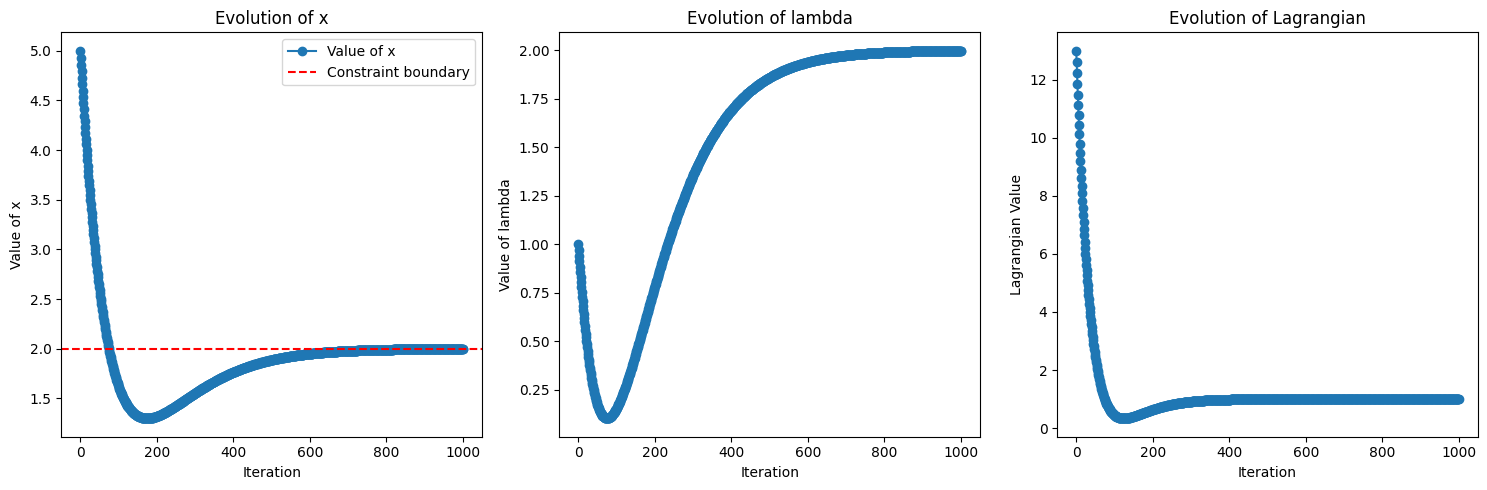

In [110]:
import matplotlib.pyplot as plt

# Plot value of x over iterations
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(x_kkt_history, '-o', label='Value of x')
plt.axhline(y=2, color='r', linestyle='--', label='Constraint boundary')
plt.xlabel('Iteration')
plt.ylabel('Value of x')
plt.legend()
plt.title('Evolution of x')

# Plot value of lambda over iterations
plt.subplot(1, 3, 2)
plt.plot(lambda_kkt_history, '-o', label='Value of lambda')
plt.xlabel('Iteration')
plt.ylabel('Value of lambda')
plt.title('Evolution of lambda')

# Plot Lagrangian value over iterations
plt.subplot(1, 3, 3)
plt.plot(lagrangian_kkt_history, '-o', label='Lagrangian value')
plt.xlabel('Iteration')
plt.ylabel('Lagrangian Value')
plt.title('Evolution of Lagrangian')

plt.tight_layout()
plt.show()


In [ ]:
#nested version, g only depends on the y-player (inner-player) 

In [291]:
import jax
import jax.numpy as jnp
import optax

# Define the Lagrangian
def lagrangian(x, y, lam):
    f = x**2 - y**2 
    #g = 2 - x
    g = -4 + y

    return f + lam * g

# Gradient of the Lagrangian with respect to x and lambda
grad_lagrangian_x = jax.jit(jax.grad(lagrangian, argnums=0))
grad_lagrangian_y = jax.jit(jax.grad(lagrangian, argnums=1))
grad_lagrangian_lambda = jax.jit(jax.grad(lagrangian, argnums=2))

# Modify the gradient functions to always return gradients for both 'x' and 'lambda'
def combined_gradients(params):
    grad_x = grad_lagrangian_x(params['x'], params['y'], params['lambda'])
    grad_y = -1*grad_lagrangian_y(params['x'], params['y'], params['lambda'])
    grad_lambda = grad_lagrangian_lambda(params['x'], params['y'], params['lambda']) # negative because we want to maximize lambda
    return {'x': grad_x, 'y':grad_y, 'lambda': grad_lambda}

# Jit-compile the combined gradient function
grad_fn_combined = jax.jit(combined_gradients)

# Optimization setup
optimizer = optax.sgd(0.005)

# Starting values for x and lambda
params = {'x': jnp.array(5.0), 'y':jnp.array(-5.0),'lambda': jnp.array(10.0)}
opt_state = optimizer.init(params)

# Lists to store history of x, lambda, and Lagrangian values
x_kkt_history = [params['x']]
y_kkt_history = [params['y']]
lambda_kkt_history = [params['lambda']]
lagrangian_kkt_history = [lagrangian(params['x'], params['y'], params['lambda'])]

# KKT conditions loop with combined gradient updates
constraint_hit = 0
for n in range(10000):
    # Update both x and lambda using combined gradients
    grads = grad_fn_combined(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    
    # Enforce dual feasibility (lambda >= 0)
    params['lambda'] = jnp.maximum(0, params['lambda'])
    
    if params['lambda'] > 0 and constraint_hit == 0:
        constraint_hit = n
    # Store values in history
    x_kkt_history.append(params['x'])
    y_kkt_history.append(params['y'])
    lambda_kkt_history.append(params['lambda'])
    lagrangian_kkt_history.append(lagrangian(params['x'], params['y'], params['lambda']))


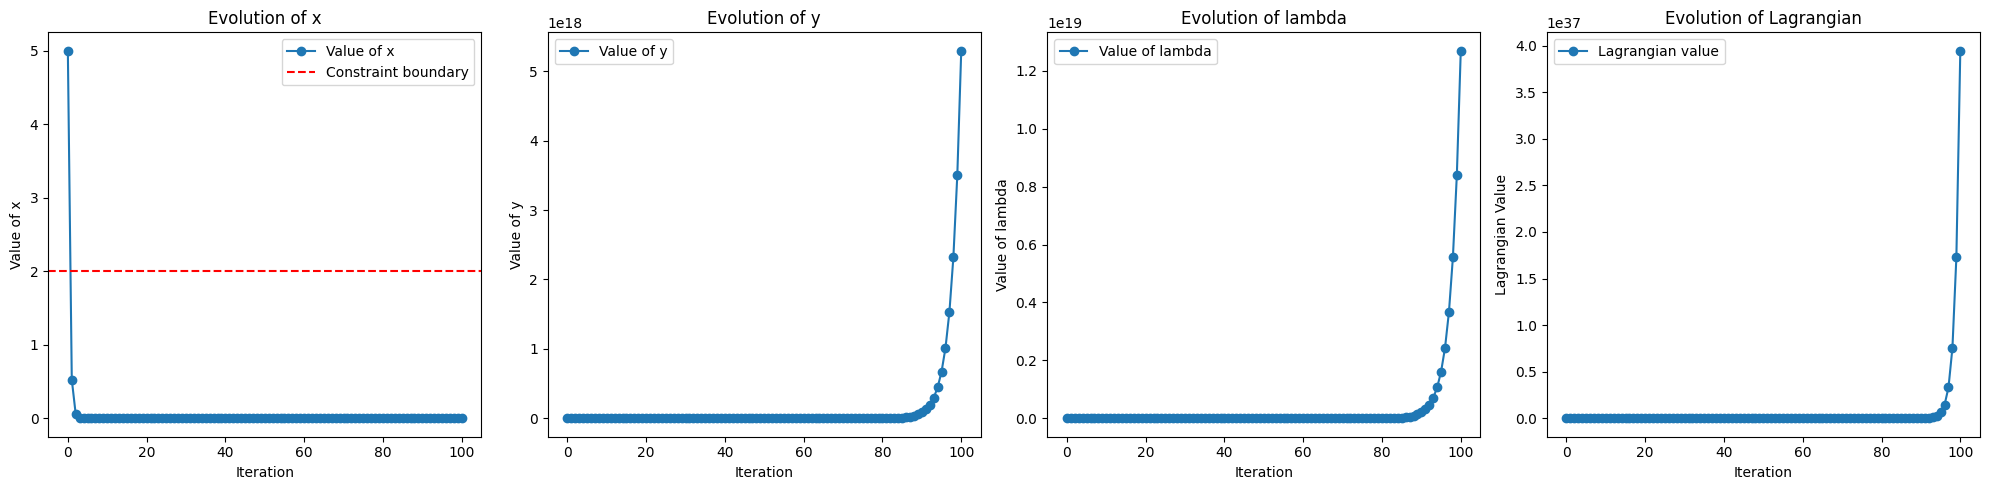

In [298]:
import matplotlib.pyplot as plt

# Plot values over iterations
plt.figure(figsize=(20, 5))

# Evolution of x
plt.subplot(1, 4, 1)
plt.plot(x_kkt_history, '-o', label='Value of x')
plt.axhline(y=2, color='r', linestyle='--', label='Constraint boundary')
plt.xlabel('Iteration')
plt.ylabel('Value of x')
plt.legend()
plt.title('Evolution of x')

# Evolution of y
plt.subplot(1, 4, 2)
plt.plot(y_kkt_history, '-o', label='Value of y')
plt.xlabel('Iteration')
plt.ylabel('Value of y')
plt.legend()
plt.title('Evolution of y')

# Evolution of lambda
plt.subplot(1, 4, 3)
plt.plot(lambda_kkt_history, '-o', label='Value of lambda')
plt.xlabel('Iteration')
plt.ylabel('Value of lambda')
plt.legend()
plt.title('Evolution of lambda')

# Evolution of Lagrangian
plt.subplot(1, 4, 4)
plt.plot(lagrangian_kkt_history, '-o', label='Lagrangian value')
plt.xlabel('Iteration')
plt.ylabel('Lagrangian Value')
plt.legend()
plt.title('Evolution of Lagrangian')

plt.tight_layout()
plt.show()


In [269]:
import jax
import jax.numpy as jnp
import optax

# Define the Lagrangian
def lagrangian(x, y, lam):
    f = x**2 - y**2
    #g = 2 - x
    g = 4 +  y

    return f + lam * g

# Gradient of the Lagrangian with respect to x and lambda
grad_lagrangian_x = jax.jit(jax.grad(lagrangian, argnums=0))
grad_lagrangian_y = jax.jit(jax.grad(lagrangian, argnums=1))
grad_lagrangian_lambda = jax.jit(jax.grad(lagrangian, argnums=2))

# Modify the gradient functions to always return gradients for both 'x' and 'lambda'
def combined_gradients(params):
    grad_x = grad_lagrangian_x(params['x'], params['y'], params['lambda'])
    grad_y = -1*grad_lagrangian_y(params['x'], params['y'], params['lambda'])
    grad_lambda = -1* grad_lagrangian_lambda(params['x'], params['y'], params['lambda'])
    return {'x': grad_x, 'y':grad_y, 'lambda': grad_lambda}

# Jit-compile the combined gradient function
grad_fn_combined = jax.jit(combined_gradients)

# Optimization setup
optimizer = optax.sgd(0.01)

# Starting values for x and lambda
params = {'x': jnp.array(5.0), 'y':jnp.array(-5.0),'lambda': jnp.array(10.0)}
opt_state = optimizer.init(params)

# Lists to store history of x, lambda, and Lagrangian values
x_kkt_history = [params['x']]
y_kkt_history = [params['y']]
lambda_kkt_history = [params['lambda']]
lagrangian_kkt_history = [lagrangian(params['x'], params['y'], params['lambda'])]

# KKT conditions loop with combined gradient updates
constraint_hit = 0
for n in range(100):
    # Update both x and lambda using combined gradients
    for _ in range(100):
        old_params = params
        grads = grad_fn_combined(params)
        updates, opt_state = optimizer.update(grads, opt_state)
        new_params = optax.apply_updates(params, updates)
        
        # Enforce dual feasibility (lambda >= 0)
        params['lambda'] = jnp.maximum(0, new_params['lambda'])
        params['y'] = new_params['y']
        
    old_params = params
    grads = grad_fn_combined(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    
    # Enforce dual feasibility (lambda >= 0)
    params['x'] = new_params['x']

    
    x_kkt_history.append(params['x'])
    y_kkt_history.append(params['y'])
    lambda_kkt_history.append(params['lambda'])
    lagrangian_kkt_history.append(lagrangian(params['x'], params['y'], params['lambda']))


In [267]:
y_kkt_history

[Array(-10., dtype=float32, weak_type=True),
 Array(-1.3202631, dtype=float32),
 Array(-0.17509279, dtype=float32),
 Array(-0.02322072, dtype=float32),
 Array(-0.00307952, dtype=float32),
 Array(-0.0004084, dtype=float32),
 Array(-5.416246e-05, dtype=float32),
 Array(-7.183002e-06, dtype=float32),
 Array(-9.5260674e-07, dtype=float32),
 Array(-1.2633429e-07, dtype=float32),
 Array(-1.6754395e-08, dtype=float32),
 Array(-2.2219613e-09, dtype=float32),
 Array(-2.9467548e-10, dtype=float32),
 Array(-3.907971e-11, dtype=float32),
 Array(-5.1827344e-12, dtype=float32),
 Array(-6.8733214e-13, dtype=float32),
 Array(-9.115369e-14, dtype=float32),
 Array(-1.2088762e-14, dtype=float32),
 Array(-1.6032066e-15, dtype=float32),
 Array(-2.126165e-16, dtype=float32),
 Array(-2.8197118e-17, dtype=float32),
 Array(-3.739489e-18, dtype=float32),
 Array(-4.9592926e-19, dtype=float32),
 Array(-6.576994e-20, dtype=float32),
 Array(-8.722379e-21, dtype=float32),
 Array(-1.1567583e-21, dtype=float32),
 Arra

In [240]:
# Define the modified Lagrangian
def lagrangian(params):
    x, y, lam = params['x'], params['y'], params['lambda']
    f = x ** 2 + y ** 2  # Note the addition for y^2 since we're minimizing g(y) = y^2
    constraint = y + 2
    return f + lam * constraint

# Gradient of the Lagrangian with respect to x, y, and lambda
grad_lagrangian = jax.jit(jax.grad(lagrangian, has_aux=False))

# Jit-compile the gradient function
grad_fn = grad_lagrangian

# Optimization setup
optimizer = optax.sgd(0.001)

# Starting values for x, y, and lambda
params = {'x': jnp.array(5.0), 'y': jnp.array(-5.0), 'lambda': jnp.array(1.0)}
opt_state = optimizer.init(params)

# Lists to store history of x, y, lambda, and Lagrangian values
x_history = [params['x']]
y_history = [params['y']]
lambda_history = [params['lambda']]
lagrangian_history = [lagrangian(params)]

# Optimization loop with gradient updates
# Optimization loop with gradient updates
for n in range(1000):
    # Update x, y, and lambda using their respective gradients
    grads = grad_fn(params)
    
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    
    # Enforce dual feasibility (lambda >= 0)
    params['lambda'] = jnp.maximum(0, params['lambda'])
    
    # Enforce primal feasibility for the y constraint (y <= -2)
    #params['y'] = jnp.minimum(params['y'], -2.0)
    
    # Store values in history
    x_history.append(params['x'])
    y_history.append(params['y'])
    lambda_history.append(params['lambda'])
    lagrangian_history.append(lagrangian(params))

params, x_history[-1], y_history[-1], lambda_history[-1], lagrangian_history[-1]


({'lambda': Array(1.596659, dtype=float32),
  'x': Array(0.6753219, dtype=float32),
  'y': Array(-1.3828495, dtype=float32)},
 Array(0.6753219, dtype=float32),
 Array(-1.3828495, dtype=float32),
 Array(1.596659, dtype=float32),
 Array(3.3537111, dtype=float32))

In [10]:
import jax
import jax.numpy as jnp
import optax

# Define the Lagrangian with mild L2 regularization for y
def lagrangian(x, y, lam):
    f = x**2 + y**2   # concave concave?
    #g = 2 - x 
    g = 2 - y
    return f + lam * g

# Gradient of the Lagrangian with respect to x, y, and lambda
grad_lagrangian_x = jax.jit(jax.grad(lagrangian, argnums=0))
grad_lagrangian_y = jax.jit(jax.grad(lagrangian, argnums=1))
grad_lagrangian_lambda = jax.jit(jax.grad(lagrangian, argnums=2))

# Modify the gradient functions to always return gradients for 'x', 'y', and 'lambda'
def combined_gradients(params):
    grad_x = grad_lagrangian_x(params['x'], params['y'], params['lambda'])
    grad_y = grad_lagrangian_y(params['x'], params['y'], params['lambda'])
    grad_lambda = -1* grad_lagrangian_lambda(params['x'], params['y'], params['lambda'])
    return {'x': grad_x, 'y': grad_y, 'lambda': grad_lambda}

# Jit-compile the combined gradient function
grad_fn_combined = jax.jit(combined_gradients)

# Separate optimizers with different learning rates for x, y, and lambda
optimizer_x = optax.sgd(0.001)
optimizer_y = optax.sgd(0.005)
optimizer_lambda = optax.sgd(0.005)

# Starting values for x, y, and lambda
params = {'x': jnp.array(5.0), 'y': jnp.array(5.0), 'lambda': jnp.array(1.0)}

# Separate initialization for each optimizer
opt_state_x = optimizer_x.init(params)
opt_state_y = optimizer_y.init(params)
opt_state_lambda = optimizer_lambda.init(params)

# Lists to store history of x, y, lambda, and Lagrangian values
x_kkt_history = [params['x']]
y_kkt_history = [params['y']]
lambda_kkt_history = [params['lambda']]
lagrangian_kkt_history = [lagrangian(params['x'], params['y'], params['lambda'])]

# Modified KKT conditions loop with combined gradient updates
for n in range(50):
    # Inner loop for updating y and lambda
    for _ in range(100):
        grads = grad_fn_combined(params)
        
        # Update y using its optimizer
        updates_y, opt_state_y = optimizer_y.update(grads, opt_state_y)
        params = optax.apply_updates(params, updates_y)
        
        # Update lambda using its optimizer
        updates_lambda, opt_state_lambda = optimizer_lambda.update(grads, opt_state_lambda)
        params = optax.apply_updates(params, updates_lambda)
        
        # Ensure lambda is non-negative
        params['lambda'] = jnp.maximum(0, params['lambda'])

            # Record values for history
        x_kkt_history.append(params['x'])
        y_kkt_history.append(params['y'])
        lambda_kkt_history.append(params['lambda'])
        lagrangian_kkt_history.append(lagrangian(params['x'], params['y'], params['lambda']))


    # Update x using its optimizer
    grads = grad_fn_combined(params)
    updates_x, opt_state_x = optimizer_x.update(grads, opt_state_x)
    params = optax.apply_updates(params, updates_x)



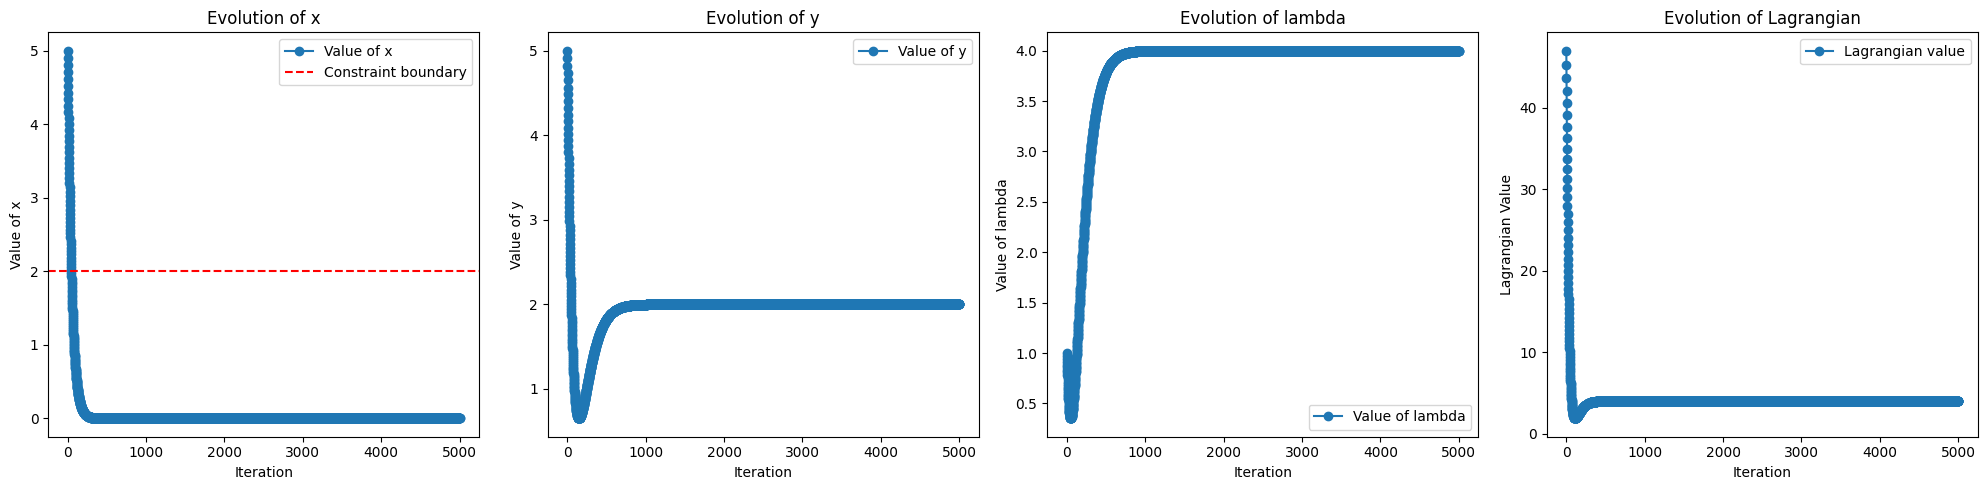

In [11]:
import matplotlib.pyplot as plt

# Plot values over iterations
plt.figure(figsize=(20, 5))

# Evolution of x
plt.subplot(1, 4, 1)
plt.plot(x_kkt_history, '-o', label='Value of x')
plt.axhline(y=2, color='r', linestyle='--', label='Constraint boundary')
plt.xlabel('Iteration')
plt.ylabel('Value of x')
plt.legend()
plt.title('Evolution of x')

# Evolution of y
plt.subplot(1, 4, 2)
plt.plot(y_kkt_history, '-o', label='Value of y')
plt.xlabel('Iteration')
plt.ylabel('Value of y')
plt.legend()
plt.title('Evolution of y')

# Evolution of lambda
plt.subplot(1, 4, 3)
plt.plot(lambda_kkt_history, '-o', label='Value of lambda')
plt.xlabel('Iteration')
plt.ylabel('Value of lambda')
plt.legend()
plt.title('Evolution of lambda')

# Evolution of Lagrangian
plt.subplot(1, 4, 4)
plt.plot(lagrangian_kkt_history, '-o', label='Lagrangian value')
plt.xlabel('Iteration')
plt.ylabel('Lagrangian Value')
plt.legend()
plt.title('Evolution of Lagrangian')

plt.tight_layout()
plt.show()


In [33]:
import jax
import jax.numpy as jnp
import optax

# Define goal g and minimal distance d_min
g = jnp.array([2.0])
d_min = 3.0

# Redefine the Lagrangian
def lagrangian(x, y, lam):
    f = jnp.sum((y - g)**2)
    g1 = d_min**2 - jnp.sum((x - y)**2)
    return f + lam * g1


# Gradient of the Lagrangian with respect to x, y, and lambda
grad_lagrangian_x = jax.jit(jax.grad(lagrangian, argnums=0))
grad_lagrangian_y = jax.jit(jax.grad(lagrangian, argnums=1))
grad_lagrangian_lambda = jax.jit(jax.grad(lagrangian, argnums=2))

# Modify the gradient functions to always return gradients for 'x', 'y', and 'lambda'
def combined_gradients(params):
    grad_x = grad_lagrangian_x(params['x'], params['y'], params['lambda'])
    grad_y = grad_lagrangian_y(params['x'], params['y'], params['lambda'])
    grad_lambda = -1* grad_lagrangian_lambda(params['x'], params['y'], params['lambda'])
    return {'x': grad_x, 'y': grad_y, 'lambda': grad_lambda}

# Jit-compile the combined gradient function
grad_fn_combined = jax.jit(combined_gradients)

# Separate optimizers with different learning rates for x, y, and lambda
optimizer_x = optax.sgd(0.001)
optimizer_y = optax.sgd(0.005)
optimizer_lambda = optax.sgd(0.005)

# Starting values for x, y, and lambda (3-dimensional vectors for x and y)
params = {'x': jnp.array([3.0]), 'y': jnp.array([5.0]), 'lambda': jnp.array(1.0)}

# Separate initialization for each optimizer
opt_state_x = optimizer_x.init(params)
opt_state_y = optimizer_y.init(params)
opt_state_lambda = optimizer_lambda.init(params)

# Lists to store history of x, y, lambda, and Lagrangian values
x_kkt_history = [params['x']]
y_kkt_history = [params['y']]
lambda_kkt_history = [params['lambda']]
lagrangian_kkt_history = [lagrangian(params['x'], params['y'], params['lambda'])]

# Modified KKT conditions loop with combined gradient updates
for n in range(50):
    # Inner loop for updating y and lambda
    for _ in range(100):
        grads = grad_fn_combined(params)
        
        # Update y using its optimizer
        updates_y, opt_state_y = optimizer_y.update(grads, opt_state_y)
        params = optax.apply_updates(params, updates_y)
        
        # Update lambda using its optimizer
        updates_lambda, opt_state_lambda = optimizer_lambda.update(grads, opt_state_lambda)
        params = optax.apply_updates(params, updates_lambda)
        
        # Ensure lambda is non-negative
        params['lambda'] = jnp.maximum(0, params['lambda'])

        # Record values for history
        x_kkt_history.append(params['x'])
        y_kkt_history.append(params['y'])
        lambda_kkt_history.append(params['lambda'])
        lagrangian_kkt_history.append(lagrangian(params['x'], params['y'], params['lambda']))

    # Update x using its optimizer
    grads = grad_fn_combined(params)
    updates_x, opt_state_x = optimizer_x.update(grads, opt_state_x)
    params = optax.apply_updates(params, updates_x)

dist_xy = jnp.array(x_kkt_history) - jnp.array(y_kkt_history)
dist_goal = jnp.array(y_kkt_history) - g

In [2]:
import jax
import jax.numpy as jnp
import optax

# Define goal g, minimal distance d_min, and weight factor alpha
goal = jnp.array([1.0])
d_min = 1.0


# Define the objective for the outer loop
def objective_outer(x, y):
    return jnp.sum((y - goal)**2)

# Redefine the Lagrangian for the inner loop
def lagrangian_inner(x, y, lam):
    f = objective_outer(x, y)
    g = d_min**2 - jnp.sum((x - y)**2) #check the signs
    return f + lam * g



# Gradient computations
grad_lagrangian_x = jax.jit(jax.grad(lagrangian_inner, argnums=0))
grad_lagrangian_y = jax.jit(jax.grad(lagrangian_inner, argnums=1))
grad_lagrangian_lambda = jax.jit(jax.grad(lagrangian_inner, argnums=2))
#grad_objective_x = jax.jit(jax.grad(objective_outer, argnums=0))

# Modify the gradient functions to always return gradients for 'x', 'y', and 'lambda'
def combined_gradients(params):
    grad_x = grad_lagrangian_x(params['x'], params['y'], params['lambda'])
    grad_y = -1*grad_lagrangian_y(params['x'], params['y'], params['lambda'])
    grad_lambda = grad_lagrangian_lambda(params['x'], params['y'], params['lambda'])
    return {'x': grad_x, 'y': grad_y, 'lambda': grad_lambda}

# Jit-compile the combined gradient function
grad_fn_combined = jax.jit(combined_gradients)

# Separate optimizers with different learning rates for x, y, and lambda
optimizer_x = optax.sgd(0.005)
optimizer_y = optax.sgd(0.005)
optimizer_lambda = optax.sgd(0.005)

# Starting values for x, y, and lambda (3-dimensional vectors for x and y)
params = {'x': jnp.array([-5.0]), 'y': jnp.array([-5.0]), 'lambda': jnp.array(1.0)}

# Separate initialization for each optimizer
opt_state_x = optimizer_x.init(params)
opt_state_y = optimizer_y.init(params)
opt_state_lambda = optimizer_lambda.init(params)

# Lists to store history of x, y, lambda, and Lagrangian values
x_kkt_history = [params['x']]
y_kkt_history = [params['y']]
lambda_kkt_history = [params['lambda']]
lagrangian_kkt_history = [lagrangian_inner(params['x'], params['y'], params['lambda'])]

# Outer loop to minimize distance between x and y
for outer in range(100):
    # Inner loop to achieve previous objectives
    for inner in range(100):
        grads = grad_fn_combined(params)
        
        # Update y
        updates_y, opt_state_y = optimizer_y.update(grads, opt_state_y)
        params = optax.apply_updates(params, updates_y)
        
        # Update lambda
        updates_lambda, opt_state_lambda = optimizer_lambda.update(grads, opt_state_lambda)
        params = optax.apply_updates(params, updates_lambda)
        
        # Ensure lambda is non-negative
        params['lambda'] = jnp.maximum(0, params['lambda'])

        # Record values for history
        x_kkt_history.append(params['x'])
        y_kkt_history.append(params['y'])
        lambda_kkt_history.append(params['lambda'])
        lagrangian_kkt_history.append(lagrangian_inner(params['x'], params['y'], params['lambda']))

    # Update x in the outer loop to minimize distance to y
    grad_x_outer = grad_lagrangian_x(params['x'], params['y'], params['lambda'])
    updates_x, opt_state_x = optimizer_x.update({'x': grad_x_outer, 'y': jnp.zeros_like(params['y']), 'lambda': jnp.zeros_like(params['lambda'])}, opt_state_x)

    params = optax.apply_updates(params, updates_x)

dist_xy = jnp.array(x_kkt_history) - jnp.array(y_kkt_history)
dist_goal = jnp.array(y_kkt_history) - goal

#jax opt for outer projection 
# fix the outer optimization '
# clip x and y to be with -1 and 1
# 

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


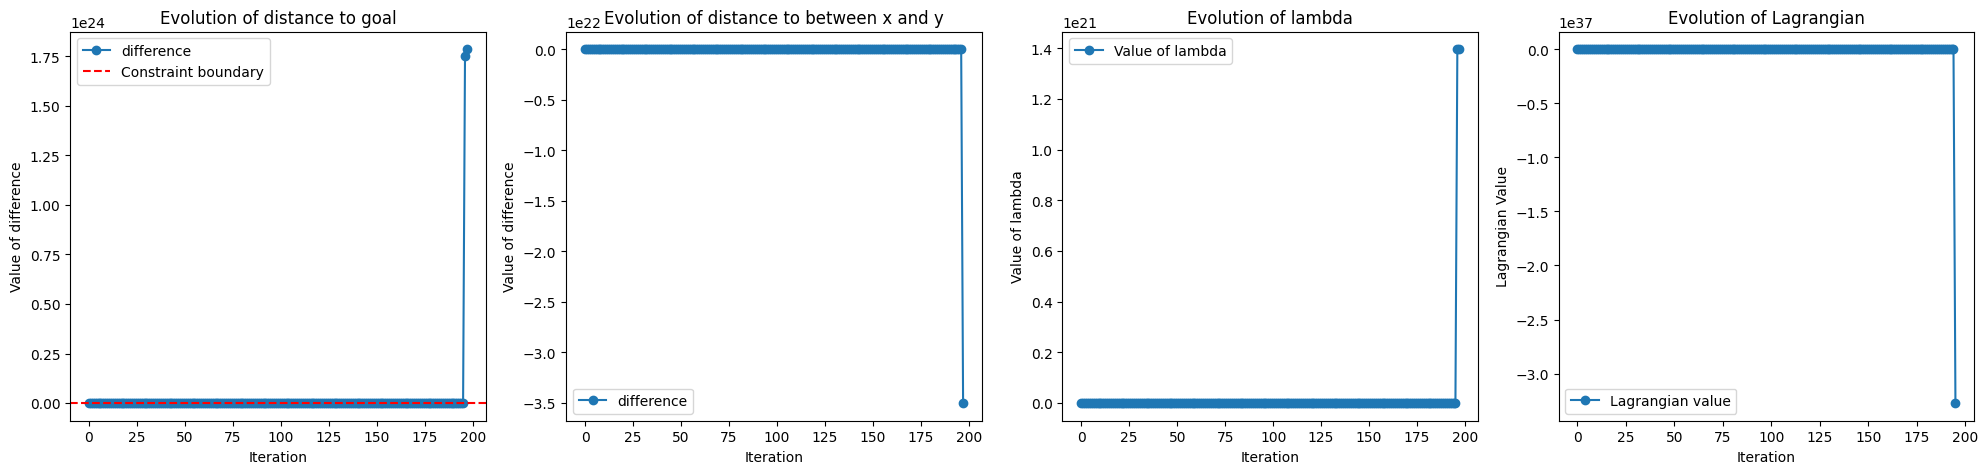

In [3]:
import matplotlib.pyplot as plt

# Plot values over iterations
plt.figure(figsize=(20, 5))

# Evolution of x
plt.subplot(1, 4, 1)
plt.plot(dist_goal, '-o', label='difference')
plt.axhline(y=2, color='r', linestyle='--', label='Constraint boundary')
plt.xlabel('Iteration')
plt.ylabel('Value of difference')
plt.legend()
plt.title('Evolution of distance to goal')

# Evolution of y
plt.subplot(1, 4, 2)
plt.plot(dist_xy, '-o', label='difference')
plt.xlabel('Iteration')
plt.ylabel('Value of difference')
plt.legend()
plt.title('Evolution of distance to between x and y')

# Evolution of lambda
plt.subplot(1, 4, 3)
plt.plot(lambda_kkt_history, '-o', label='Value of lambda')
plt.xlabel('Iteration')
plt.ylabel('Value of lambda')
plt.legend()
plt.title('Evolution of lambda')

# Evolution of Lagrangian
plt.subplot(1, 4, 4)
plt.plot(lagrangian_kkt_history, '-o', label='Lagrangian value')
plt.xlabel('Iteration')
plt.ylabel('Lagrangian Value')
plt.legend()
plt.title('Evolution of Lagrangian')

plt.tight_layout()
plt.show()


In [7]:
print(x_kkt_history[-1], y_kkt_history[-1])

[nan] [nan]


In [8]:
x_kkt_history

[Array([-5.], dtype=float32),
 Array([-5.], dtype=float32),
 Array([-4.9976244], dtype=float32),
 Array([-4.992872], dtype=float32),
 Array([-4.9857435], dtype=float32),
 Array([-4.9762306], dtype=float32),
 Array([-4.9643183], dtype=float32),
 Array([-4.949978], dtype=float32),
 Array([-4.9331646], dtype=float32),
 Array([-4.9138107], dtype=float32),
 Array([-4.891821], dtype=float32),
 Array([-4.8670673], dtype=float32),
 Array([-4.839382], dtype=float32),
 Array([-4.808552], dtype=float32),
 Array([-4.774308], dtype=float32),
 Array([-4.7363243], dtype=float32),
 Array([-4.6942015], dtype=float32),
 Array([-4.647464], dtype=float32),
 Array([-4.5955477], dtype=float32),
 Array([-4.537792], dtype=float32),
 Array([-4.4734306], dtype=float32),
 Array([-4.401578], dtype=float32),
 Array([-4.3212204], dtype=float32),
 Array([-4.231206], dtype=float32),
 Array([-4.130234], dtype=float32),
 Array([-4.016843], dtype=float32),
 Array([-3.889402], dtype=float32),
 Array([-3.7461023], dtype=f